# Análisis exploratorio

- Alumno: Javier Berlmar Tevar
- Tutor: Jose Norberto Mazón
- Cotutor: Jose Jacobo Zubcoff


Horario: Lunes a Viernes: 10-14h. Sábados, domingos y festivos: 10-14h.
4/01 y 5/01:10-14 y 17-19h. 
Festivos cerrados: 1,6/01, 1/05 y 25/12.

Alcance de sensor: 
Nombre del parámetro: WiFi RSSI Detection Threshold
Valor por defecto es -120 (máximo alcance).
Se cambia a valor -60 el 10 de mayo (mínimo alcance).
Se cambia a valor -80 (alcance intermedio) el 22 junio

---
---
## 0. Librerías

In [1]:
#### Librerías generales
import pandas as pd
from pathlib import Path
import plotly.graph_objects as go
import numpy as np

#### Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from scipy.cluster.hierarchy import dendrogram, linkage

---
---
## 1. Carga de datos

A continución se realiza la carga de datos de dos ficheros:

1. Un fichero con extensión `xlsx` (CuestionarioTouristInfoAlcoi.xlsx): Contiene las respuestas de las personas que acuden a la oficina de Turismo.
2. Un fichero con extensión `csv` (resultados_cw08.csv)

In [2]:

path = os.path.dirname(os.path.realpath('__file__'))

p = Path(path)
p = str(p.parent)


########################### CUESTIONARIO ###################################


p1 = p + '/Datos/CuestionarioTouristInfoAlcoi.xlsx'
p1 = p1.replace("\\", "/")

# se ha instalado el parquete openpyxl para que el motor de la función soporte el archivo
# pip install openpyxl (en conda prompt)
df_cuest = pd.read_excel(
     p1,
     engine='openpyxl', 
)

# renombramos campos para que sea mas sencillo operar con ellos
mapping = {df_cuest.columns[0]:'timestamp', df_cuest.columns[1]: 'residencia',
           df_cuest.columns[2]:'origen', df_cuest.columns[3]: 'num_personas',
           df_cuest.columns[4]:'num_personas_oficina', df_cuest.columns[5]: 'wifi_abierta_tlf'}
df_cuest = df_cuest.rename(columns=mapping)


df_cuest['date'] = df_cuest['timestamp'].dt.date

########################### SENSOR ###################################


p2 = p + '/Datos/resultados_cw08.csv'
p2 = p2.replace("\\", "/")

df_sensor = pd.read_csv(p2, sep = ';')

df_sensor = df_sensor.rename(columns={'date': 'timestamp'})
df_sensor.timestamp = pd.to_datetime(df_sensor.timestamp)

df_sensor['date'] = df_sensor['timestamp'].dt.date

########################### SSID's Alcoy ###################################

p3 = p + '/Datos/resultados_ssid_alcoi.csv'
p3 = p3.replace("\\", "/")

df_ssid_alcoy = pd.read_csv(p3, sep = ';')

---
---
## 2.Visualización del estado de los conjuntos

A continuación se obtiene una vista previa de lo que nos vamos a encontrar en los datasets.

### 1. Datos recogidos por la oficina de turismo:

In [3]:
df_cuest.head()

,timestamp,residencia,origen,num_personas,num_personas_oficina,wifi_abierta_tlf,date
0,2020-11-27 12:22:02.791,Alcoi,NaN,1,1,Sí,2020-11-27
1,2020-11-27 17:17:22.383,Alcoi,NaN,1,1,Sí,2020-11-27
2,2020-11-27 18:02:33.662,Comunidad Valenciana,Valencia,2,2,No,2020-11-27
3,2020-11-28 10:16:21.630,Comunidad Valenciana,Valencia,5,3,Sí,2020-11-28
4,2020-11-28 11:05:25.625,Alcoi,NaN,2,2,No,2020-11-28


### 2. Datos recogidos por el sensor de Hopu.

In [4]:
df_sensor.head()

,timestamp,sensor,ssid,mac,visitor,date
0,2020-12-21 12:30:26.336,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21
1,2020-12-21 12:30:26.336,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21
2,2020-12-21 12:30:27.443,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21
3,2020-12-21 12:30:27.443,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21
4,2020-12-21 12:30:31.944,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21


### 3. Datos de todos los ssid's existentes recogidos por los sensores. 

Cruzado de datos con el fichero que contiene las ssid's que son de Alcoi (capturadas por el dispositivo). A continuación se muestra el fichero que contiene las ssid's de las redes Wifi localizadas en Alcoi

In [5]:
# nos quedamos con la columna relevante
df_ssid_alcoy = df_ssid_alcoy[["ssid"]]
df_ssid_alcoy = df_ssid_alcoy.dropna(subset=["ssid"])
df_ssid_alcoy.head()

,ssid
2,00ccba5c6f7925e1fc70b2e0893852bf596c88c2
3,0143a4fa9f588990add630753c676a2c5961232d
4,015075bd5ebf650fa28d9016af6a4a50e25cb153
5,01593e9505926488c67e8cc24b8fc3de53f7dace
6,0185884ec4753ec27be08b3ee0bc7086b4db5ee4


Se obtienen los visitantes (visitor_v2) según ssid's recogidos por los sensores de Alcoi.

In [6]:
list_ssid = df_ssid_alcoy['ssid'].tolist()

def f(row):
    if row['ssid'] in list_ssid:
        val = 'Y'
    else:
        val = 'N'
    return val

#df_sensor['visitor_v2'] = np.where(df_sensor['ssid'] in list_ssid, "Y", "N")
df_sensor['visitor_v2'] = df_sensor.apply(f, axis=1)

df_sensor.head()

,timestamp,sensor,ssid,mac,visitor,date,visitor_v2
0,2020-12-21 12:30:26.336,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21,N
1,2020-12-21 12:30:26.336,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21,N
2,2020-12-21 12:30:27.443,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21,N
3,2020-12-21 12:30:27.443,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21,N
4,2020-12-21 12:30:31.944,CW08,cada330f25b98b5e0d44da5fc3decb161d337b4a,b627731c6c589cdabd7b02e979f7019c1d1efcf4,Y,2020-12-21,N


---
---
## 3. Análisis exploratorio

### <u>**Nulos:**</u> Primero comprobamos los nulos para cada conjunto:

1. Cuestionario:

In [7]:
df_cuest.isna().sum()

timestamp                 0
residencia                0
origen                  520
num_personas              0
num_personas_oficina      0
wifi_abierta_tlf          0
date                      0
dtype: int64

Se observan nulos en el campo de origen del cuestionario, en este caso no hay problema, pues que sea nulo depende directamente de la pregunta anterior del cuestionario. Concretamente, si en la anterior pregunta (segunda pregunta): "¿Cúal es su lugar de residencia?" se contesta Alcoi, la respuesta a la siguiente pregunta (tercera) figurará vacía, ya que se deberá especificar el origen en ese caso. Por tanto, lo que va a realizar es un relleno de los campos nulos con "Alcoi".

In [8]:
df_cuest = df_cuest.fillna("Alcoi")
df_cuest.isna().sum()

timestamp               0
residencia              0
origen                  0
num_personas            0
num_personas_oficina    0
wifi_abierta_tlf        0
date                    0
dtype: int64

2. Sensor:

In [9]:
df_sensor.isna().sum()

timestamp         0
sensor            0
ssid              2
mac               1
visitor       68444
date              0
visitor_v2        0
dtype: int64

Se observa que gran parte de los nulos cae sobre el campo visitor, de lo cual no hay que preocuparse porque es nuestra tarea principal la estimación del mismo. Se procederá a eliminar los registros en los que en los campos de ssid y mac haya algún nulo.

In [10]:
# df_sensor = df_sensor.drop(['visitor'], axis=1) # primero borramos la columna irrelevante
df_sensor = df_sensor.dropna(subset=["ssid", "mac"])
df_sensor.isna().sum()

timestamp         0
sensor            0
ssid              0
mac               0
visitor       68442
date              0
visitor_v2        0
dtype: int64

---
### <u>**Descripción de los datos:**</u> percentiles y desviación estándar:

1. Cuestionario:

In [11]:
data = df_cuest
perc =[.20, .40, .60, .80]
desc = data.describe(percentiles=perc, include='all', datetime_is_numeric=True)
desc

,timestamp,residencia,origen,num_personas,num_personas_oficina,wifi_abierta_tlf,date
count,1410,1410,1410,1410.000000,1410.000000,1410,1410
unique,NaN,4,239,NaN,NaN,3,183
top,NaN,Comunidad Valenciana,Alcoi,NaN,NaN,Sí,2021-04-04
freq,NaN,729,520,NaN,NaN,848,41
mean,2021-03-15 02:23:07.244278784,NaN,NaN,1.118440,0.858865,NaN,NaN
min,2020-11-27 12:22:02.791000,NaN,NaN,0.000000,0.000000,NaN,NaN
20%,2020-12-19 14:04:55.633400064,NaN,NaN,0.000000,0.000000,NaN,NaN
40%,2021-03-13 13:54:27.152800256,NaN,NaN,1.000000,1.000000,NaN,NaN
50%,2021-04-02 13:59:58.656999936,NaN,NaN,1.000000,1.000000,NaN,NaN
60%,2021-04-10 12:53:59.550000128,NaN,NaN,1.000000,1.000000,NaN,NaN


2. Sensor

In [12]:
data = df_sensor
desc = data.describe(datetime_is_numeric=True)
desc

,timestamp
count,83074
mean,2021-03-25 18:28:19.652264704
min,2020-12-21 12:30:26.336000
25%,2021-03-01 14:43:03.506999808
50%,2021-03-29 12:46:59.307500032
75%,2021-04-23 14:08:04.634999808
max,2021-07-08 10:08:15.358000


---
### <u>Campos cuestionario:</u> A continuación, se realiza un breve análisis exploratorio sobre los campos del conjunto de datos del cuestionario. 

**date:** Fecha (día) de realización del cuestionario.





In [13]:
df_cuest['date'].value_counts().sort_values()

2021-01-21     1
2021-06-17     1
2021-03-09     1
2021-01-24     1
2021-02-15     1
              ..
2021-04-02    26
2020-12-06    29
2021-01-04    29
2021-04-03    33
2021-04-04    41
Name: date, Length: 183, dtype: int64

---
**residencia:** Lugar de residencia de los visitantes a la oficina de turismo de Alcoi.

Obtenemos el número de residentes por cada categoría de localización.

In [14]:
df_cuest['residencia'].value_counts().sort_values()

Internacional            68
España                  102
Alcoi                   511
Comunidad Valenciana    729
Name: residencia, dtype: int64

---
**origen:** Lugar originario del/de los visitantes.



In [15]:
df_cuest['origen'].value_counts().sort_values()

BENIFAIÓ           1
Fuerteventura      1
Puçol              1
ALEMANIA           1
BELGIUM            1
                ... 
Alicante          28
Alicante          52
Valencia         117
Valencia         190
Alcoi            520
Name: origen, Length: 239, dtype: int64

---
**num_personas:** Número de personas del grupo con el que ha viajado. 

In [16]:
df_cuest['num_personas'].value_counts().sort_values()

8       1
7       1
10      2
9       2
6       2
5       9
4      34
3     106
2     162
0     402
1     689
Name: num_personas, dtype: int64

---
**num_personas_oficina:** Número de personas con el que ha viajado y ha entrado a la oficina.

In [17]:
df_cuest['num_personas_oficina'].value_counts().sort_values()

5      2
4     17
3     58
2    146
0    520
1    667
Name: num_personas_oficina, dtype: int64

---
**wifi_abierta_tlf:** Marca (Sí/No) si la persona tiene la red wifi del teléfono activa 

In [18]:
df_cuest['wifi_abierta_tlf'].value_counts().sort_values()

No entiendo la pregunta    123
No                         439
Sí                         848
Name: wifi_abierta_tlf, dtype: int64

### <u>Campos sensor:</u> A continuación, se realiza un breve análisis exploratorio sobre los campos del conjunto de datos del sensor.

**date:** Fecha de registro del dispositivo.

In [19]:
df_sensor['date'].value_counts().sort_values()

2021-05-29       2
2021-06-20       2
2021-06-19       3
2021-05-20       3
2021-05-23       3
              ... 
2021-03-18    1695
2021-05-06    1746
2021-02-24    1822
2021-05-05    1878
2021-04-15    2140
Name: date, Length: 161, dtype: int64

---
**sensor:** Id del sensor que ha refgistrado el dispositivo

In [20]:
df_sensor['sensor'].value_counts().sort_values()

CW08    83074
Name: sensor, dtype: int64

Se está haciendo el análisis para un solo sensor que está ubicado en la oficina de turismo

---
## **ssid:**
ssid de la red Wifi preferida por el dispositivo registrado.

In [21]:
df_sensor['ssid'].value_counts().sort_values()

82b76b0b42491648654bb32aab7a3fc5dbe87579        1
87f4fcc07fa0d0f4771acf638834c84ad9cff3a4        1
88dab7ce488083fb6301e6de51169819b058969b        1
3b3a67ca84dbf4f3c6c194c9edede69a111a5ff4        1
0e1d51e806453e5ff40222f5d4e3b434a07a5662        1
                                            ...  
87b1965f588f3dc856ecaac238aaeaac1a71f247     1107
2e4d03b0c09a73f874b341a33152129c5bba5011     1652
d75f15af8afffe8c66e9863c1a4dfcad8e98a056     2271
ffd2edd79fe4bac98610a2ad6892b53395e44e34    16256
cca78a1e963f3ba3443bf3e54a9aa939f73d223d    38355
Name: ssid, Length: 3860, dtype: int64

Hay ssid's registradas que destacan (en número) sobre las demás. Utilizar para algoritmo de clasificación (e.g. rpart).
Gráfica --> regla del codo. Estas ssid's nos servirán para compararlas con las ssid's que recogidas que solo pertenecen a Alcoi


In [22]:
df_aux = pd.DataFrame(df_sensor['ssid'].value_counts().sort_values())
df_aux.reset_index(inplace=True)
df_aux.rename(columns={"index": "ssid", "ssid": "counts"}, inplace=True)
df_aux['ssid_id'] = range(0, len(df_aux))

df_aux.head()

,ssid,counts,ssid_id
0,82b76b0b42491648654bb32aab7a3fc5dbe87579,1,0
1,87f4fcc07fa0d0f4771acf638834c84ad9cff3a4,1,1
2,88dab7ce488083fb6301e6de51169819b058969b,1,2
3,3b3a67ca84dbf4f3c6c194c9edede69a111a5ff4,1,3
4,0e1d51e806453e5ff40222f5d4e3b434a07a5662,1,4


In [23]:
fig = go.Figure(
    data=[go.Scatter(x=df_aux['ssid_id'], y=df_aux['counts'])],
    
)


fig.update_layout(
    title = dict(text = "SSID Frecuencias"),
    xaxis=dict(rangeslider=dict(visible=True)  
    )
)

### <u>Clustering</u>

Regla del codo: Para determinar el parámetro K (número de clusters) , uno de los métodos a utilizar es la regla del codo en el SSE (Error Sum of Squares).

In [24]:
distortions = []
for i in range(1, 14):
    km_model = KMeans(n_clusters=i)
    km_model.fit(df_aux[['counts']])
    distortions.append(km_model.inertia_)


x = np.arange(14)
fig = go.Figure(data=go.Scatter(x=x, y=distortions))
fig.update_layout(
    title="Regla del codo SSID clustering óptimo",
    xaxis_title="Número de clusters",
    yaxis_title="SSE",
    legend_title="SSE",
)

Método de la silueta: El otro método que se empleará es selección de cluster por puntuación de la silueta, este sirve para evaluar la calidad de los clusters.

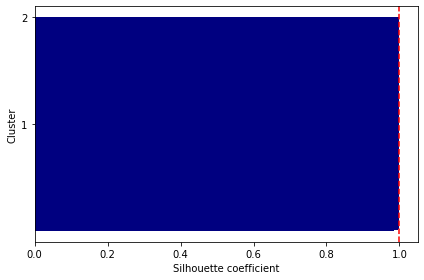

In [25]:
km = KMeans(n_clusters=2)
y_km = km.fit_predict(df_aux[['counts']])

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(df_aux[['counts']], y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

In [26]:
km = KMeans(n_clusters=2)

y_km = km.fit_predict(df_aux[['counts']])
df_y_km = pd.DataFrame(y_km, columns = ['counts_clust']).reset_index(drop=True)

# clusters
df_y_km['counts_clust'].value_counts().sort_values()
#df_y_km.tail(10)

1       1
0    3859
Name: counts_clust, dtype: int64

# Dendograma

In [27]:
"""
OTRA FORMA

import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))
"""


linked = linkage(df_aux[['counts']], 'single')

labelList = range(0, len(df_aux.ssid_id))



"""
VERSION matplot

plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()
"""




"""
VERSION PLOTLY
"""
np.random.seed(1)

X = linked # 15 samples, with 12 dimensions each
fig = ff.create_dendrogram(X)
fig.update_layout(width=800, height=500)
fig.show()


In [28]:
X = np.random.rand(15, 12)
X


array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
        1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
        3.96767474e-01, 5.38816734e-01, 4.19194514e-01, 6.85219500e-01],
       [2.04452250e-01, 8.78117436e-01, 2.73875932e-02, 6.70467510e-01,
        4.17304802e-01, 5.58689828e-01, 1.40386939e-01, 1.98101489e-01,
        8.00744569e-01, 9.68261576e-01, 3.13424178e-01, 6.92322616e-01],
       [8.76389152e-01, 8.94606664e-01, 8.50442114e-02, 3.90547832e-02,
        1.69830420e-01, 8.78142503e-01, 9.83468338e-02, 4.21107625e-01,
        9.57889530e-01, 5.33165285e-01, 6.91877114e-01, 3.15515631e-01],
       [6.86500928e-01, 8.34625672e-01, 1.82882773e-02, 7.50144315e-01,
        9.88861089e-01, 7.48165654e-01, 2.80443992e-01, 7.89279328e-01,
        1.03226007e-01, 4.47893526e-01, 9.08595503e-01, 2.93614148e-01],
       [2.87775339e-01, 1.30028572e-01, 1.93669579e-02, 6.78835533e-01,
        2.11628116e-01, 2.65546659e-01, 4.91573159e-01, 5.33

---

## **mac:**
Identificador (Media Access Control) del dispositivo identificado por el sensor, puede ser variable. 

In [29]:
df_sensor['mac'].value_counts().sort_values()

624420c7a67ea6cdfeffa92f8705600bebc5dc88       1
dfbb1fa15edf23cc3d0f91ff857ec12f72fc5f86       1
d6bdba1a668971a94e8ac51cdbd159a600109f53       1
06732d603e6e8d19a8a71970b3f85a46b0efa654       1
7bad9d35da8ca2fcd30ba7c1beab8947542fc633       1
                                            ... 
5cbcffeab5fa9206a8c2712ef085daab688dd086    2450
7ecc4c8bbd75b66d0d0c04096e161e9b2f65a428    4574
6ec65bc349733bc0e85d17294d3a9cb6d8b8bdc8    7585
d29675014f618f3ef3f6b75f146b4be71c513c16    7599
292128facc8342026c849a8ae3b1fbbcb0573291    7956
Name: mac, Length: 25285, dtype: int64

Vamos a adaptar estos datos para obtener una gráfica que nos muestre de una manera más intuitiva lo que está sucediendo con las mac's. Primero preparamos los datos. El objetivo de la gráfica es comprobar si existe un cambio pronunciado en la frecuencia con la que aparecen las mac. De esta forma se podría intuir qué dispositivos aparecen en el sensor de la oficina y cuales no. Si aparecen con mucha frecuencia, se podría decir que son mac's de dispositivos pertencientes a empleados de la oficina. 

In [30]:
df_aux = pd.DataFrame(df_sensor['mac'].value_counts().sort_values())
df_aux.reset_index(inplace=True)
df_aux.rename(columns={"index": "mac", "mac": "counts"}, inplace=True)
df_aux['mac_id'] = range(0, len(df_aux))

In [31]:
df_aux.head()

,mac,counts,mac_id
0,624420c7a67ea6cdfeffa92f8705600bebc5dc88,1,0
1,dfbb1fa15edf23cc3d0f91ff857ec12f72fc5f86,1,1
2,d6bdba1a668971a94e8ac51cdbd159a600109f53,1,2
3,06732d603e6e8d19a8a71970b3f85a46b0efa654,1,3
4,7bad9d35da8ca2fcd30ba7c1beab8947542fc633,1,4


In [32]:
fig = go.Figure(
    data=[go.Scatter(x=df_aux['mac_id'], y=df_aux['counts'])],
    
)


fig.update_layout(
    title = dict(text = "MAC Frecuencias"),
    xaxis=dict(rangeslider=dict(visible=True)  
    )
)

In [33]:
df_aux.head(3)
#df_aux['counts2'] = df_aux['counts'] # es una artimaña para que funcione el clustering, necesita al menos dos columnas

,mac,counts,mac_id
0,624420c7a67ea6cdfeffa92f8705600bebc5dc88,1,0
1,dfbb1fa15edf23cc3d0f91ff857ec12f72fc5f86,1,1
2,d6bdba1a668971a94e8ac51cdbd159a600109f53,1,2


### <u>Clustering</u>

In [34]:
distortions = []
for i in range(1, 14):
    km_model = KMeans(n_clusters=i)
    km_model.fit(df_aux[['counts']])
    distortions.append(km_model.inertia_)


x = np.arange(14)
fig = go.Figure(data=go.Scatter(x=x, y=distortions))
fig.update_layout(
    title="Regla del codo MAC clustering óptimo",
    xaxis_title="Número de clusters",
    yaxis_title="SSE",
    legend_title="SSE",
)

In [35]:

"""
df_aux_tree_set = df_aux.copy()
sensor_tree = DecisionTreeClassifier(random_state=0)
sensor_tree.fit(x_train_c1, y_train_c1)
"""

km = KMeans(n_clusters=2)

y_km = km.fit_predict(df_aux[['counts']])
df_y_km = pd.DataFrame(y_km, columns = ['counts_clust']).reset_index(drop=True)

# clusters
df_y_km['counts_clust'].value_counts().sort_values()
#df_y_km.tail(10)

1        4
0    25281
Name: counts_clust, dtype: int64

Se observa como por medio del clustering, un algoritmo de aprendizaje no supervisado, separa en dos clusters las MAC's que se han repetido 427 veces o más (en este caso). Esto puede servir como apoyo a las heurístcas para discernir si el dispisitvo (identificado por su MAC) es pertenciente una persona residente en Alcoy o no.

---
**visitor:** Valor booleano que nos dice si es vistante o no (Y/N)

In [36]:
df_sensor['visitor'].value_counts().sort_values()

N      963
Y    13669
Name: visitor, dtype: int64

## Heurísticas de detección

1. MAC repetida (alg. clasificación: rpart + gráfica + clustering): Siginificará que ese dispositivo, si se repite mucho, muy probablente sea residente en Alcoi. Se deberá de llevar cuidado con este campo pues hay algunos dispositivos que cambian de MAC.

2. ssid repetida (alg. clasificación: rpart + gráfica + clustering): Si esa id de Wifi favorita figura en las reconocidas por el dispositivo dentro de Alcoi será residente de Alcoi.

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#ffe5d9;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:black;">
    En esta visualización se obtienen las proporciones de accidentes por distrito. El distrito en el que ocurren más accidentes es el de Salamanca seguido de Chamartín. Seguramente es porque se sitúan en el centro y sean de los lugares de Madrid más concurridos.
</p>
</div>

Preguntas y Anotaciones:

- ¿Se tiene el ssid de la oficina de turismo? es para ver si coincide con el ssid que más se repite en la gráfica del ssid del sensor de la oficina de turimo.
- Debo juntar en el Dataframe del sensor (al principio) si la ssid pertenece a una localizada en el conjunto de todas la ssids recogidas de Alcoy. 